<a href="https://colab.research.google.com/github/Niloy-24/Transfer-Learning-Based-Classification-Of-Eye-Disease/blob/main/EfficientNetB7_NormalVsEyelid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
PATH = '/content/gdrive/MyDrive/Thesis/Data/NormalVsEyelid/'
train_dir = os.path.join(PATH, 'Train')
test_dir = os.path.join(PATH, 'Test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1519 files belonging to 2 classes.


In [4]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 363 files belonging to 2 classes.


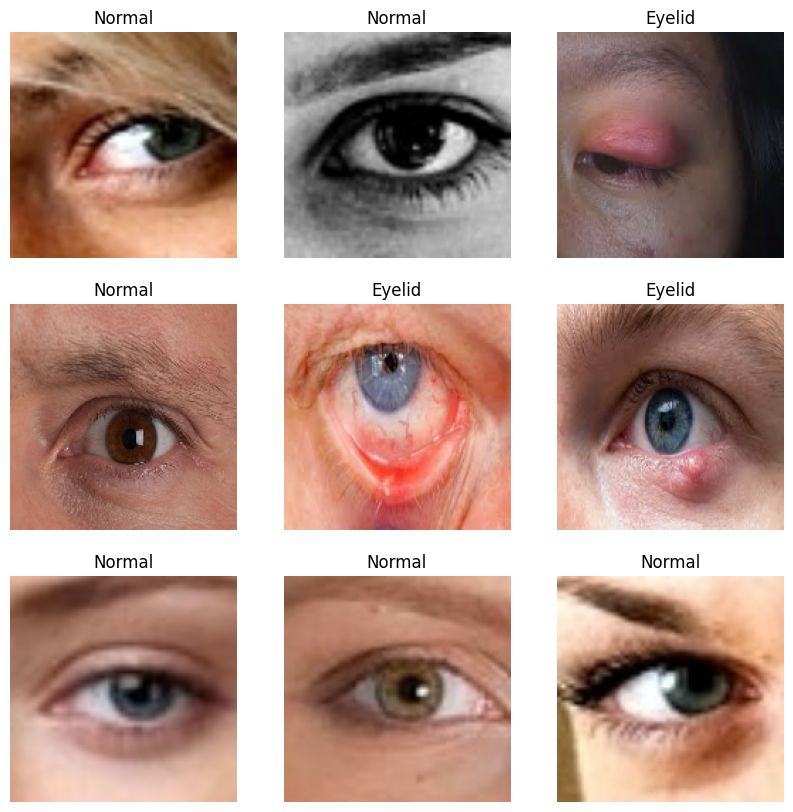

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
test_batches = tf.data.experimental.cardinality(test_dataset)
val_dataset = test_dataset.take(test_batches // 7)
val_dataset = test_dataset.skip(test_batches // 7)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 12


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

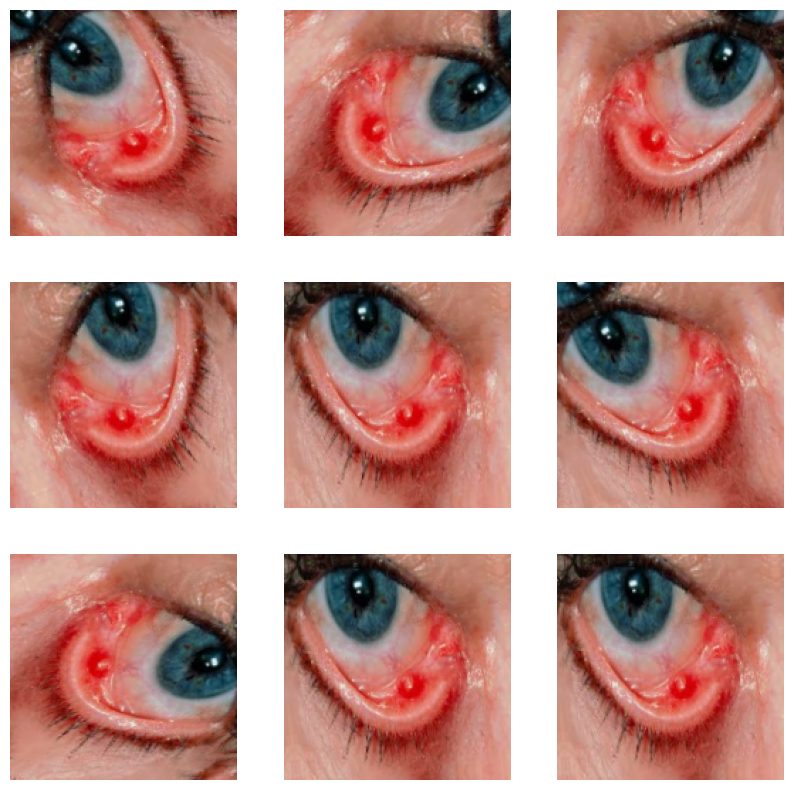

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.efficientnet.EfficientNetB7
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

258076736/258076736 [==============================] - 17s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2560)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 160, 160, 3)  0           ['normalization[0][0

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2560)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                             

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_dataset)

11/11 [==============================] - 125s 1s/step - loss: 8.4417 - accuracy: 0.4441


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.44
initial accuracy: 0.44


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/50
48/48 [==============================] - 225s 4s/step - loss: 8.0874 - accuracy: 0.4700 - val_loss: 8.5308 - val_accuracy: 0.4471
Epoch 2/50
48/48 [==============================] - 12s 254ms/step - loss: 8.0817 - accuracy: 0.4740 - val_loss: 8.6711 - val_accuracy: 0.4381
Epoch 3/50
48/48 [==============================] - 12s 255ms/step - loss: 7.9866 - accuracy: 0.4733 - val_loss: 8.2782 - val_accuracy: 0.4441
Epoch 4/50
48/48 [==============================] - 12s 250ms/step - loss: 2.5378 - accuracy: 0.5984 - val_loss: 1.7894 - val_accuracy: 0.4955
Epoch 5/50
48/48 [==============================] - 13s 254ms/step - loss: 0.8202 - accuracy: 0.7255 - val_loss: 1.0665 - val_accuracy: 0.4230
Epoch 6/50
48/48 [==============================] - 12s 255ms/step - loss: 0.5280 - accuracy: 0.7926 - val_loss: 0.9329 - val_accuracy: 0.5196
Epoch 7/50
48/48 [==============================] - 13s 257ms/step - loss: 0.5342 - accuracy: 0.8012 - val_loss: 0.8877 - val_accuracy: 0.4834
E

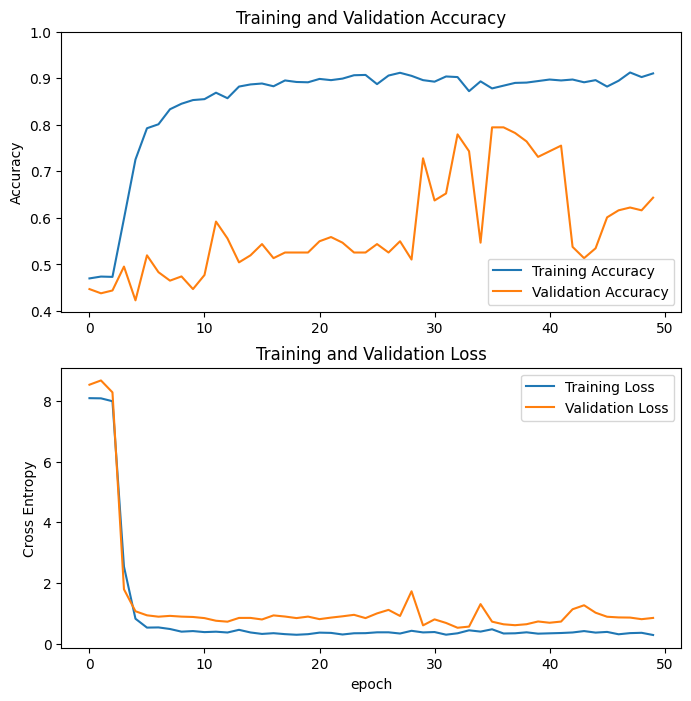

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[fine_tune_at:]:
  layer.trainable = True

Number of layers in the base model:  6


In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                             

In [29]:
len(model.trainable_variables)

711

In [30]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 50/100
48/48 [==============================] - 181s 1s/step - loss: 0.3142 - accuracy: 0.9309 - val_loss: 1.3069 - val_accuracy: 0.6133
Epoch 51/100
48/48 [==============================] - 47s 978ms/step - loss: 0.1546 - accuracy: 0.9513 - val_loss: 0.5876 - val_accuracy: 0.8187
Epoch 52/100
48/48 [==============================] - 48s 985ms/step - loss: 0.0771 - accuracy: 0.9776 - val_loss: 0.3726 - val_accuracy: 0.9124
Epoch 53/100
48/48 [==============================] - 47s 980ms/step - loss: 0.0798 - accuracy: 0.9809 - val_loss: 0.5746 - val_accuracy: 0.8671
Epoch 54/100
48/48 [==============================] - 49s 1s/step - loss: 0.0500 - accuracy: 0.9888 - val_loss: 0.5653 - val_accuracy: 0.8882
Epoch 55/100
48/48 [==============================] - 47s 978ms/step - loss: 0.0532 - accuracy: 0.9914 - val_loss: 0.7007 - val_accuracy: 0.8792
Epoch 56/100
48/48 [==============================] - 47s 971ms/step - loss: 0.0276 - accuracy: 0.9921 - val_loss: 0.2690 - val_accurac

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

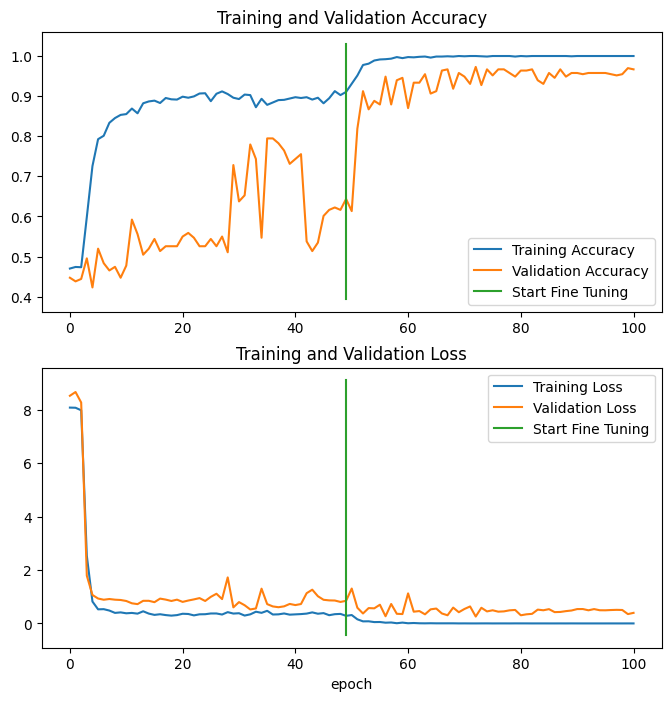

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 3s 186ms/step - loss: 0.3621 - accuracy: 0.9697
Test accuracy : 0.9696969985961914


Predictions:
 [0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0]
Labels:
 [0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0]


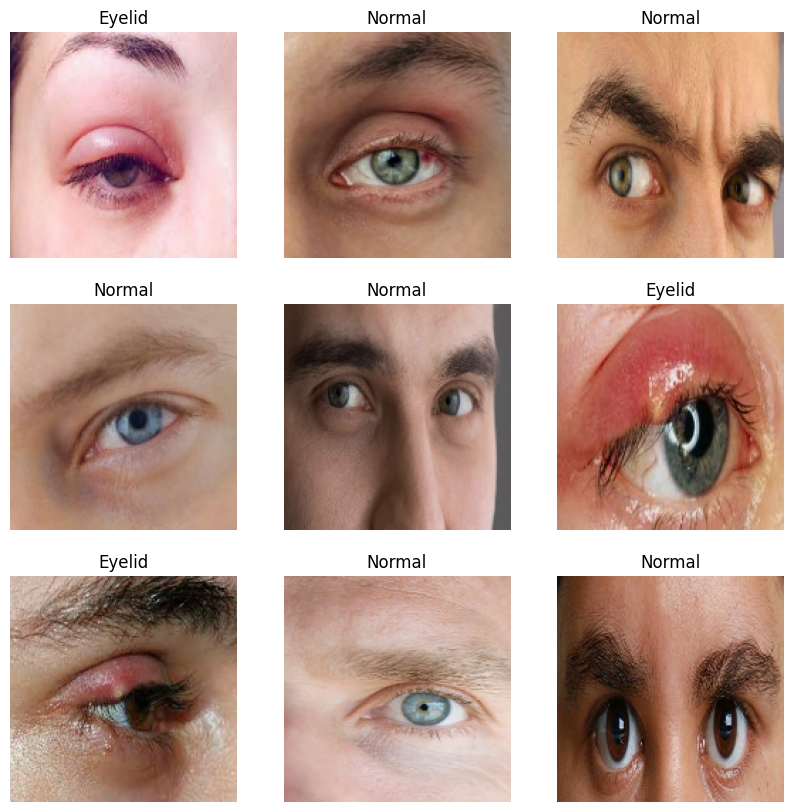

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")